In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
import pickle
import random

from pymongo import MongoClient
from pprint import pprint

#### EDA: Closed Listings 

In [2]:
client = MongoClient()

In [3]:
db = client.sold

In [4]:
db.collection_names()

<ipython-input-4-8ff4d2505e25>:1: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  db.collection_names()


['closed_listing']

In [5]:
tmp = list(db.closed_listing.find({}, {'_id':0, 'listing_id':1, 'property_id':1, 'description':1, 'list_date':1, 'list_price':1, 'location':1, 'status':1}))

In [6]:
#Convert into pandas df
df = pd.json_normalize(tmp)

In [7]:
df.head()

,status,list_date,list_price,property_id,listing_id,description.year_built,description.baths_3qtr,description.sold_date,description.sold_price,description.baths_full,...,location.address.state,location.address.coordinate.lon,location.address.coordinate.lat,location.address.city,location.address.state_code,location.address.line,location.street_view_url,location.county.fips_code,location.county.name,location.county
0,sold,2021-06-15T15:05:55Z,1549000.0,2507173757,2930532060,1926.0,NaN,2021-07-16,1760000,2.0,...,California,-118.276835,34.085110,Los Angeles,CA,3380 Descanso Dr,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
1,sold,2021-04-09T21:02:06Z,879000.0,1681184474,2927976112,2008.0,NaN,2021-07-16,850000,1.0,...,California,-118.263194,34.040804,Los Angeles,CA,1155 S Grand Ave Apt 1807,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
2,sold,2021-06-05T00:02:43Z,849000.0,2913082626,2930168949,1912.0,NaN,2021-07-16,1016000,2.0,...,California,-118.314134,34.023169,Los Angeles,CA,3563 S Gramercy Pl,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
3,sold,2021-06-29T16:08:40Z,1499000.0,1415870805,2931114156,1900.0,NaN,2021-07-16,1625000,3.0,...,California,-118.267025,34.079045,Los Angeles,CA,1107 Waterloo St,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
4,sold,2021-05-20T16:00:15Z,395000.0,2820635269,2929515091,1985.0,NaN,2021-07-16,385000,1.0,...,California,-118.295523,33.930572,Los Angeles,CA,11401 Berendo Ave Apt 6,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN


In [8]:
#The original API data contains duplicate rows
df2 = df.drop_duplicates()

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79654 entries, 0 to 243197
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   status                           79654 non-null  object 
 1   list_date                        79653 non-null  object 
 2   list_price                       79648 non-null  float64
 3   property_id                      79654 non-null  object 
 4   listing_id                       79654 non-null  object 
 5   description.year_built           74070 non-null  float64
 6   description.baths_3qtr           4032 non-null   float64
 7   description.sold_date            79654 non-null  object 
 8   description.sold_price           79654 non-null  int64  
 9   description.baths_full           73280 non-null  float64
 10  description.name                 0 non-null      object 
 11  description.baths_half           19522 non-null  float64
 12  description.lot_s

In [10]:
cols_to_keep= ['property_id', 'listing_id', 'status', 'list_date','list_price', 'description.sold_price','description.year_built', 'description.baths_3qtr', 'description.sold_date',
                 'description.baths_full','description.baths_half','description.lot_sqft','description.sqft','description.baths','description.type','description.garage',
                 'description.stories','description.beds','location.address.postal_code','location.address.state','location.address.coordinate.lon','location.address.coordinate.lat',
                 'location.address.city','location.address.state_code','location.address.line','location.county.fips_code','location.county.name']

df2 = df2[cols_to_keep]

In [11]:
df2 = df2[df2['description.sqft'] > 0]

In [12]:
df2 = df2[df2['list_price'].notnull()]
df2 = df2[df2['description.year_built'].notnull()]
df2 = df2[df2['description.type'] != 'land']
df2 = df2[df2['location.address.postal_code'].notnull()]
df2 = df2[df2['location.address.state'] == 'California']
df2 = df2[(df2['location.address.coordinate.lon'].notnull()) & (df2['location.address.coordinate.lat'].notnull())]
df2 = df2[df2['location.address.postal_code'] != '96141'] # remove an outlier
df2 = df2[df2['location.address.city'].notnull()]

In [13]:
#clean up data types
df2['description.year_built'] = df2['description.year_built'].astype(int)


In [46]:
#save into pickle
with open('closed_listings_cleaned.pickle', 'wb') as to_write:
    pickle.dump(df2, to_write)
    

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72662 entries, 0 to 243197
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_id                      72662 non-null  object 
 1   listing_id                       72662 non-null  object 
 2   status                           72662 non-null  object 
 3   list_date                        72661 non-null  object 
 4   list_price                       72662 non-null  float64
 5   description.sold_price           72662 non-null  int64  
 6   description.year_built           72662 non-null  int64  
 7   description.baths_3qtr           3825 non-null   float64
 8   description.sold_date            72662 non-null  object 
 9   description.baths_full           71011 non-null  float64
 10  description.baths_half           19044 non-null  float64
 11  description.lot_sqft             66486 non-null  float64
 12  description.sqft 

#### EDA Active Listings

In [16]:
client = MongoClient()

In [17]:
db = client.sales

In [18]:
db.collection_names()

<ipython-input-18-8ff4d2505e25>:1: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  db.collection_names()


['active_listing']

In [19]:
tmp = list(db.active_listing.find({}, {'_id':0, 'listing_id':1, 'property_id':1, 'description':1, 'list_date':1, 'list_price':1, 'location':1, 'status':1}))

In [20]:
#Convert into pandas df
df_sale = pd.json_normalize(tmp)

In [21]:
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242290 entries, 0 to 242289
Data columns (total 31 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   status                           242290 non-null  object 
 1   list_date                        242290 non-null  object 
 2   list_price                       242052 non-null  float64
 3   property_id                      242290 non-null  object 
 4   listing_id                       240749 non-null  object 
 5   description.baths_3qtr           12790 non-null   float64
 6   description.year_built           214385 non-null  float64
 7   description.sold_price           186268 non-null  float64
 8   description.baths_full           214862 non-null  float64
 9   description.name                 1541 non-null    object 
 10  description.baths_half           54432 non-null   float64
 11  description.lot_sqft             218922 non-null  float64
 12  de

In [22]:
#The original API data contains duplicate rows
df_sale2 = df_sale.drop_duplicates()

In [23]:
df_sale2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76055 entries, 0 to 242289
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   status                           76055 non-null  object 
 1   list_date                        76055 non-null  object 
 2   list_price                       75975 non-null  float64
 3   property_id                      76055 non-null  object 
 4   listing_id                       75437 non-null  object 
 5   description.baths_3qtr           3403 non-null   float64
 6   description.year_built           62003 non-null  float64
 7   description.sold_price           55166 non-null  float64
 8   description.baths_full           62838 non-null  float64
 9   description.name                 618 non-null    object 
 10  description.baths_half           16455 non-null  float64
 11  description.lot_sqft             69447 non-null  float64
 12  description.sqft 

In [24]:
df_sale2 = df_sale2[df_sale2['list_price'].notnull()]
df_sale2 = df_sale2[df_sale2['description.year_built'].notnull()]
df_sale2 = df_sale2[df_sale2['description.type'] != 'land']
df_sale2 = df_sale2[df_sale2['location.address.postal_code'].notnull()]
df_sale2 = df_sale2[df_sale2['location.address.state'] == 'California']
df_sale2 = df_sale2[(df_sale2['location.address.coordinate.lon'].notnull()) & (df_sale2['location.address.coordinate.lat'].notnull())]
df_sale2 = df_sale2[df_sale2['location.address.city'].notnull()]

In [25]:
df_sale2.head()

,status,list_date,list_price,property_id,listing_id,description.baths_3qtr,description.year_built,description.sold_price,description.baths_full,description.name,...,location.address.state,location.address.coordinate.lon,location.address.coordinate.lat,location.address.city,location.address.state_code,location.address.line,location.street_view_url,location.county.fips_code,location.county.name,location.county
0,for_sale,2021-07-17T03:04:48Z,499999.0,1411833579,2931884576,NaN,1929.0,NaN,1.0,None,...,California,-118.262770,33.963001,Los Angeles,CA,701 E 84th St,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
1,for_sale,2021-07-17T02:49:37Z,588000.0,1556491989,2931884324,NaN,1912.0,310000.0,3.0,None,...,California,-118.247656,34.005150,Los Angeles,CA,4317 Compton Ave,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
2,for_sale,2021-07-17T02:45:24Z,750000.0,2893986016,2931884270,NaN,1922.0,443000.0,9.0,None,...,California,-118.244392,33.975767,Los Angeles,CA,7017 Converse Ave,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
3,for_sale,2021-07-17T01:15:16Z,725000.0,2896408303,2931882619,NaN,1925.0,280000.0,3.0,None,...,California,-118.277277,33.976759,Los Angeles,CA,233 W 70th St,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
4,for_sale,2021-07-17T00:20:13Z,420000.0,2472720430,2931881129,NaN,1927.0,120000.0,1.0,None,...,California,-118.232771,33.937322,Los Angeles,CA,10806 Juniper St,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN


In [26]:
df_sale2['list_date'] = df_sale2['list_date'].apply(lambda x: x.split('T')[0])

In [27]:
df_sale2.head()

,status,list_date,list_price,property_id,listing_id,description.baths_3qtr,description.year_built,description.sold_price,description.baths_full,description.name,...,location.address.state,location.address.coordinate.lon,location.address.coordinate.lat,location.address.city,location.address.state_code,location.address.line,location.street_view_url,location.county.fips_code,location.county.name,location.county
0,for_sale,2021-07-17,499999.0,1411833579,2931884576,NaN,1929.0,NaN,1.0,None,...,California,-118.262770,33.963001,Los Angeles,CA,701 E 84th St,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
1,for_sale,2021-07-17,588000.0,1556491989,2931884324,NaN,1912.0,310000.0,3.0,None,...,California,-118.247656,34.005150,Los Angeles,CA,4317 Compton Ave,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
2,for_sale,2021-07-17,750000.0,2893986016,2931884270,NaN,1922.0,443000.0,9.0,None,...,California,-118.244392,33.975767,Los Angeles,CA,7017 Converse Ave,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
3,for_sale,2021-07-17,725000.0,2896408303,2931882619,NaN,1925.0,280000.0,3.0,None,...,California,-118.277277,33.976759,Los Angeles,CA,233 W 70th St,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN
4,for_sale,2021-07-17,420000.0,2472720430,2931881129,NaN,1927.0,120000.0,1.0,None,...,California,-118.232771,33.937322,Los Angeles,CA,10806 Juniper St,https://maps.googleapis.com/maps/api/streetvie...,06037,Los Angeles,NaN


#### Append closed listings to active listings:
#### 1. append by zip and property type
#### 2. calculate distance by using lat and lon beteen each active listing and their appended closed listings. This is to find top10 closed sold properties for each active listing-- For APP use.

In [29]:
all_listings = df_sale2.merge(df2,
                             on = ['location.address.postal_code','description.type'],
                              how = 'left'
                            )

In [30]:
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3393405 entries, 0 to 3393404
Data columns (total 56 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   status_x                           object 
 1   list_date_x                        object 
 2   list_price_x                       float64
 3   property_id_x                      object 
 4   listing_id_x                       object 
 5   description.baths_3qtr_x           float64
 6   description.year_built_x           float64
 7   description.sold_price_x           float64
 8   description.baths_full_x           float64
 9   description.name                   object 
 10  description.baths_half_x           float64
 11  description.lot_sqft_x             float64
 12  description.sqft_x                 float64
 13  description.baths_x                float64
 14  description.sub_type               object 
 15  description.baths_1qtr             float64
 16  description.garage

In [31]:
all_listings.head()

,status_x,list_date_x,list_price_x,property_id_x,listing_id_x,description.baths_3qtr_x,description.year_built_x,description.sold_price_x,description.baths_full_x,description.name,...,description.stories_y,description.beds_y,location.address.state_y,location.address.coordinate.lon_y,location.address.coordinate.lat_y,location.address.city_y,location.address.state_code_y,location.address.line_y,location.county.fips_code_y,location.county.name_y
0,for_sale,2021-07-17,499999.0,1411833579,2931884576,NaN,1929.0,NaN,1.0,None,...,2.0,3.0,California,-118.245756,33.982249,Los Angeles,CA,1571 E Gage Ave,06037,Los Angeles
1,for_sale,2021-07-17,499999.0,1411833579,2931884576,NaN,1929.0,NaN,1.0,None,...,1.0,3.0,California,-118.252864,33.973667,Los Angeles,CA,1242 E 73rd St,06037,Los Angeles
2,for_sale,2021-07-17,499999.0,1411833579,2931884576,NaN,1929.0,NaN,1.0,None,...,1.0,2.0,California,-118.259468,33.960801,Los Angeles,CA,834 E 85th St,06037,Los Angeles
3,for_sale,2021-07-17,499999.0,1411833579,2931884576,NaN,1929.0,NaN,1.0,None,...,1.0,3.0,California,-118.262392,33.970004,Los Angeles,CA,714 E 76th Pl,06037,Los Angeles
4,for_sale,2021-07-17,499999.0,1411833579,2931884576,NaN,1929.0,NaN,1.0,None,...,1.0,3.0,California,-118.253821,33.981369,Los Angeles,CA,1204 E 64th St,06037,Los Angeles


In [32]:
all_listings['X_diff'] = all_listings['location.address.coordinate.lon_x'] - all_listings['location.address.coordinate.lon_y']
all_listings['Y_diff'] = all_listings['location.address.coordinate.lat_x'] - all_listings['location.address.coordinate.lat_y']

In [33]:
all_listings['dist'] = np.linalg.norm(all_listings[['X_diff', 'Y_diff']], axis=1)

In [34]:
all_listings = all_listings.sort_values(['dist'],ascending=True).groupby(['property_id_x','listing_id_x']).head(10)

In [35]:
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542081 entries, 907116 to 3393027
Data columns (total 59 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   status_x                           542081 non-null  object 
 1   list_date_x                        542081 non-null  object 
 2   list_price_x                       542081 non-null  float64
 3   property_id_x                      542081 non-null  object 
 4   listing_id_x                       542081 non-null  object 
 5   description.baths_3qtr_x           30155 non-null   float64
 6   description.year_built_x           542081 non-null  float64
 7   description.sold_price_x           447139 non-null  float64
 8   description.baths_full_x           536287 non-null  float64
 9   description.name                   0 non-null       object 
 10  description.baths_half_x           142138 non-null  float64
 11  description.lot_sqft_x           

In [36]:
all_listings.columns

Index(['status_x', 'list_date_x', 'list_price_x', 'property_id_x',
       'listing_id_x', 'description.baths_3qtr_x', 'description.year_built_x',
       'description.sold_price_x', 'description.baths_full_x',
       'description.name', 'description.baths_half_x',
       'description.lot_sqft_x', 'description.sqft_x', 'description.baths_x',
       'description.sub_type', 'description.baths_1qtr',
       'description.garage_x', 'description.stories_x', 'description.beds_x',
       'description.type', 'location.address.postal_code',
       'location.address.state_x', 'location.address.coordinate.lon_x',
       'location.address.coordinate.lat_x', 'location.address.city_x',
       'location.address.state_code_x', 'location.address.line_x',
       'location.street_view_url', 'location.county.fips_code_x',
       'location.county.name_x', 'location.county', 'property_id_y',
       'listing_id_y', 'status_y', 'list_date_y', 'list_price_y',
       'description.sold_price_y', 'description.year_

In [37]:
final_df = all_listings[['listing_id_x','property_id_x','status_x','list_date_x','list_price_x','description.year_built_x',
                       'description.baths_x','description.garage_x','description.stories_x', 'description.beds_x',
                       'description.type', 'location.address.postal_code', 'location.address.line_x','location.address.city_x',
                        'description.lot_sqft_x', 'description.sqft_x',
                       'property_id_y','listing_id_y','list_price_y','description.sold_price_y', 'description.year_built_y',
                       'description.sold_date','description.lot_sqft_y', 'description.sqft_y', 'description.baths_y','description.beds_y',
                         'location.address.city_y',
                        'location.address.line_y']]

In [38]:
final_df.head()

,listing_id_x,property_id_x,status_x,list_date_x,list_price_x,description.year_built_x,description.baths_x,description.garage_x,description.stories_x,description.beds_x,...,list_price_y,description.sold_price_y,description.year_built_y,description.sold_date,description.lot_sqft_y,description.sqft_y,description.baths_y,description.beds_y,location.address.city_y,location.address.line_y
907116,2931339032,2158559976,for_sale,2021-07-06,434950.0,1975.0,1.0,1.0,1.0,1.0,...,394000.0,399000.0,1975.0,2021-07-09,428195.0,653.0,1.0,1.0,San Diego,1775 Diamond St Unit 121
370636,2931803397,2652943692,for_sale,2021-07-15,499900.0,1988.0,2.0,NaN,1.0,2.0,...,460000.0,505000.0,1989.0,2021-06-26,NaN,1252.0,2.0,2.0,Yorba Linda,5215 Box Canyon Ct Unit 20H
2348749,2929560849,2211677120,for_sale,2021-05-21,1388000.0,2003.0,3.0,2.0,2.0,4.0,...,1468000.0,1468000.0,2002.0,2021-07-06,NaN,2387.0,3.0,4.0,Irvine,207 Tuberose
370635,2931803397,2652943692,for_sale,2021-07-15,499900.0,1988.0,2.0,NaN,1.0,2.0,...,525000.0,529000.0,1988.0,2021-07-01,NaN,1252.0,2.0,2.0,Yorba Linda,5265 Box Canyon Ct Unit 24A
370632,2931803397,2652943692,for_sale,2021-07-15,499900.0,1988.0,2.0,NaN,1.0,2.0,...,490000.0,480000.0,1989.0,2021-07-02,NaN,1252.0,2.0,2.0,Yorba Linda,5205 Box Canyon Ct Unit 19D


In [39]:
final_df.columns

Index(['listing_id_x', 'property_id_x', 'status_x', 'list_date_x',
       'list_price_x', 'description.year_built_x', 'description.baths_x',
       'description.garage_x', 'description.stories_x', 'description.beds_x',
       'description.type', 'location.address.postal_code',
       'location.address.line_x', 'location.address.city_x',
       'description.lot_sqft_x', 'description.sqft_x', 'property_id_y',
       'listing_id_y', 'list_price_y', 'description.sold_price_y',
       'description.year_built_y', 'description.sold_date',
       'description.lot_sqft_y', 'description.sqft_y', 'description.baths_y',
       'description.beds_y', 'location.address.city_y',
       'location.address.line_y'],
      dtype='object')

In [40]:
final_df.rename(columns = {'listing_id_x': 'listing_id',
                'property_id_x': 'property_id',
                'status_x': 'status',
                'list_date_x':'list_date',
                'list_price_x':'list_price',
                'description.year_built_x':'year_built',
                'description.baths_x':'baths',
                'description.garage_x':'garage',
                'description.stories_x':'stories',
                'description.beds_x':'beds',
                'description.type' :'type',
                'location.address.postal_code':'postal_code',
                'location.address.line_x': 'address',
                'location.address.city_x': 'city',
                'description.lot_sqft_x':'lot_sqft',
                'description.sqft_x':'sqft',
                'property_id_y':'property_id_sold',
                'description.sold_price_y':'price_sold',
                'description.year_built_y':'year_built_sold',
                'description.sold_date':'sold_date',
                'description.lot_sqft_y':'lot_sqft_sold',
                'description.sqft_y':'sqft_sold',
                'escription.baths_y':'baths_sold',
                'description.beds_y':'beds_sold',
                'description.baths_y':'bath_sold',
                'location.address.line_y':'address_sold'
                }, inplace = True)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [41]:
final_df.head()

,listing_id,property_id,status,list_date,list_price,year_built,baths,garage,stories,beds,...,list_price_y,price_sold,year_built_sold,sold_date,lot_sqft_sold,sqft_sold,bath_sold,beds_sold,location.address.city_y,address_sold
907116,2931339032,2158559976,for_sale,2021-07-06,434950.0,1975.0,1.0,1.0,1.0,1.0,...,394000.0,399000.0,1975.0,2021-07-09,428195.0,653.0,1.0,1.0,San Diego,1775 Diamond St Unit 121
370636,2931803397,2652943692,for_sale,2021-07-15,499900.0,1988.0,2.0,NaN,1.0,2.0,...,460000.0,505000.0,1989.0,2021-06-26,NaN,1252.0,2.0,2.0,Yorba Linda,5215 Box Canyon Ct Unit 20H
2348749,2929560849,2211677120,for_sale,2021-05-21,1388000.0,2003.0,3.0,2.0,2.0,4.0,...,1468000.0,1468000.0,2002.0,2021-07-06,NaN,2387.0,3.0,4.0,Irvine,207 Tuberose
370635,2931803397,2652943692,for_sale,2021-07-15,499900.0,1988.0,2.0,NaN,1.0,2.0,...,525000.0,529000.0,1988.0,2021-07-01,NaN,1252.0,2.0,2.0,Yorba Linda,5265 Box Canyon Ct Unit 24A
370632,2931803397,2652943692,for_sale,2021-07-15,499900.0,1988.0,2.0,NaN,1.0,2.0,...,490000.0,480000.0,1989.0,2021-07-02,NaN,1252.0,2.0,2.0,Yorba Linda,5205 Box Canyon Ct Unit 19D


In [42]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542081 entries, 907116 to 3393027
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   listing_id               542081 non-null  object 
 1   property_id              542081 non-null  object 
 2   status                   542081 non-null  object 
 3   list_date                542081 non-null  object 
 4   list_price               542081 non-null  float64
 5   year_built               542081 non-null  float64
 6   baths                    540486 non-null  float64
 7   garage                   428237 non-null  float64
 8   stories                  508201 non-null  float64
 9   beds                     541250 non-null  float64
 10  type                     542081 non-null  object 
 11  postal_code              542081 non-null  object 
 12  address                  540501 non-null  object 
 13  city                     542081 non-null  object 
 14

In [43]:
with open('df_final.pickle', 'wb') as to_write:
    pickle.dump(final_df, to_write)

In [47]:
#Visuals
df2.head()

,property_id,listing_id,status,list_date,list_price,description.sold_price,description.year_built,description.baths_3qtr,description.sold_date,description.baths_full,...,description.beds,location.address.postal_code,location.address.state,location.address.coordinate.lon,location.address.coordinate.lat,location.address.city,location.address.state_code,location.address.line,location.county.fips_code,location.county.name
0,2507173757,2930532060,sold,2021-06-15T15:05:55Z,1549000.0,1760000,1926,NaN,2021-07-16,2.0,...,3.0,90026,California,-118.276835,34.085110,Los Angeles,CA,3380 Descanso Dr,06037,Los Angeles
1,1681184474,2927976112,sold,2021-04-09T21:02:06Z,879000.0,850000,2008,NaN,2021-07-16,1.0,...,1.0,90015,California,-118.263194,34.040804,Los Angeles,CA,1155 S Grand Ave Apt 1807,06037,Los Angeles
2,2913082626,2930168949,sold,2021-06-05T00:02:43Z,849000.0,1016000,1912,NaN,2021-07-16,2.0,...,2.0,90018,California,-118.314134,34.023169,Los Angeles,CA,3563 S Gramercy Pl,06037,Los Angeles
3,1415870805,2931114156,sold,2021-06-29T16:08:40Z,1499000.0,1625000,1900,NaN,2021-07-16,3.0,...,5.0,90026,California,-118.267025,34.079045,Los Angeles,CA,1107 Waterloo St,06037,Los Angeles
4,2820635269,2929515091,sold,2021-05-20T16:00:15Z,395000.0,385000,1985,NaN,2021-07-16,1.0,...,2.0,90044,California,-118.295523,33.930572,Los Angeles,CA,11401 Berendo Ave Apt 6,06037,Los Angeles


In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72662 entries, 0 to 243197
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_id                      72662 non-null  object 
 1   listing_id                       72662 non-null  object 
 2   status                           72662 non-null  object 
 3   list_date                        72661 non-null  object 
 4   list_price                       72662 non-null  float64
 5   description.sold_price           72662 non-null  int64  
 6   description.year_built           72662 non-null  int64  
 7   description.baths_3qtr           3825 non-null   float64
 8   description.sold_date            72662 non-null  object 
 9   description.baths_full           71011 non-null  float64
 10  description.baths_half           19044 non-null  float64
 11  description.lot_sqft             66486 non-null  float64
 12  description.sqft 

In [75]:
property_sold_by_zip = df2.groupby(['location.address.postal_code'])['property_id'].count().reset_index()
property_sold_by_zip.rename(columns = {"property_id":"sold"}, inplace = True)

In [78]:
property_sold_by_zip_top5 = property_sold_by_zip.sort_values(by = 'sold', ascending = False).head(5)

In [79]:
property_sold_by_zip_top5.head()

,location.address.postal_code,sold
1323,95667,284
751,93561,278
1341,95687,257
1367,95747,247
1050,95023,247


Text(0.5, 0, 'zipcode')

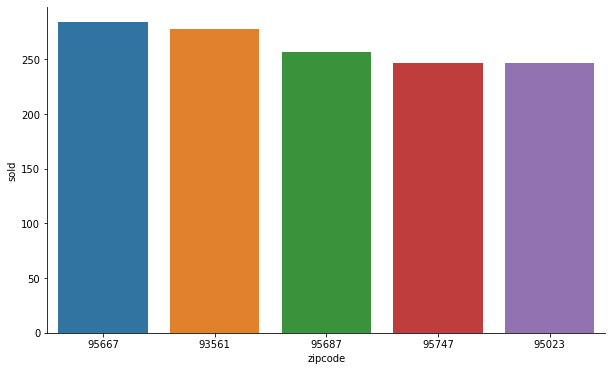

In [89]:
from matplotlib.pyplot import figure

figure(figsize =(10,6))
sns.barplot(x='location.address.postal_code', y = 'sold',data = property_sold_by_zip_top5)
sns.despine(bottom = False, left = False)

plt.xlabel("zipcode")

In [91]:
df2['price_sqrt'] = df2['description.sold_price']/(df2['description.lot_sqft'] + df2['description.sqft'])

In [94]:
medianprice_by_zip = df2.groupby(['location.address.postal_code'])['price_sqrt'].median().reset_index()
medianprice_by_zip.rename(columns = {"price_sqrt":"median_price_sqrt"}, inplace = True)

In [96]:
medianprice_by_zip_top5 = medianprice_by_zip.sort_values(by = 'median_price_sqrt', ascending = False).head(5)

In [97]:
medianprice_by_zip_top5.head()

,location.address.postal_code,median_price_sqrt
884,94123,630.759054
556,92662,624.877954
555,92661,620.572377
145,90742,514.970778
81,90254,506.904387


Text(0, 0.5, 'Median Price Per SQRT')

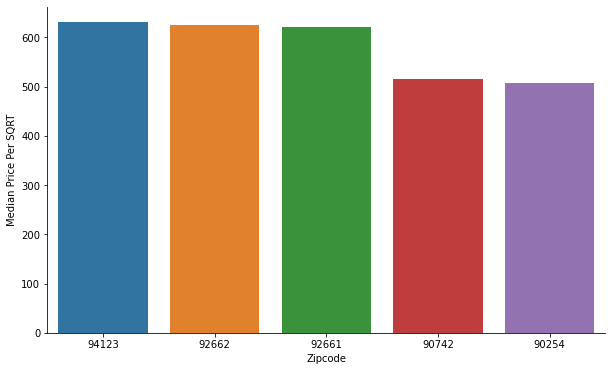

In [100]:
figure(figsize =(10,6))
sns.barplot(x='location.address.postal_code', y = 'median_price_sqrt',data = medianprice_by_zip_top5)
sns.despine(bottom = False, left = False)

plt.xlabel("Zipcode")
plt.ylabel("Median Price Per SQRT")